In [4]:
using Random
using Distributions
using LinearAlgebra
include("../Inversion/Plot.jl")
include("../Inversion/KalmanInversion.jl")
include("../Inversion/RWMCMC.jl")

emcee_Run

# 2-Parameter Elliptic Equation : Probabilistic Approach
Consider the one-dimensional elliptic boundary-value problem

$$
    -\frac{d}{dx}\Big(\exp(\theta_{(1)}) \frac{d}{dx}p(x)\Big) = 1, \qquad x\in[0,1]
$$

with boundary conditions $p(0) = 0$ and $p(1) = \theta_{(2)}$. The solution for this problem is given by  

$$
    p(x) = \theta_{(2)} x + \exp(-\theta_{(1)})\Big(-\frac{x^2}{2} + \frac{x}{2}\Big).
$$

The inverse problem is to solve for $\theta = (\theta_{(1)},\, \theta_{(2)})^T$ with the observations $y = (p(x_1),\,p(x_2))^T$ at $x_1=0.25$ and $x_2=0.75$.
The Bayesian inverse problem is formulated as 

$$
    y = \mathcal{G}(\theta) + \eta \qquad \textrm{and} \qquad 
    \mathcal{G}(\theta) = \begin{bmatrix}
    p(x_1, \theta)\\
    p(x_2, \theta)
    \end{bmatrix},
$$
here $\mathcal{G}(\theta)$ is the forward model operator. And the prior is $\mathcal{N}([0, 100]^T,  I)$. We consider two scenarios  

* Well-posed case ：the observation is $y=[27.5, 79.7]^T$ with observation error $\eta\sim\mathcal{N}(0, 0.1^2 I)$. 

* Ill-posed case ：the observation is $y=[27.5]$ with observation error $\eta\sim\mathcal{N}(0, 0.1^2 I)$. 



The numerical experiment considered here is a counterexample against the ensemble Kalman filter, which is proposed in [1] and further used in [2,3]. 

1. Ernst, Oliver G and Sprungk, Björn and Starkloff, Hans-Jörg, "Analysis of the ensemble and polynomial chaos Kalman filters in Bayesian inverse problems"

2. Herty, Michael and Visconti, Giuseppe, "Kinetic methods for inverse problems"

3. Garbuno-Inigo, Alfredo and Hoffmann, Franca and Li, Wuchen and Stuart, Andrew M, "Interacting Langevin diffusions: Gradient structure and ensemble Kalman sampler


In [5]:
mutable struct Setup_Param{IT<:Int}
    θ_names::Array{String,1}
    N_θ::IT
    N_y::IT
end

function Setup_Param(N_θ::IT, N_y::IT) where {IT<:Int}
    return Setup_Param(["θ"], N_θ, N_y)
end

function forward(s_param, θ::Array{Float64,1})
    x1, x2 = 0.25, 0.75
    θ1, θ2 = θ
    p = (x) -> θ2*x + exp(-θ1)*(-x^2/2 + x/2)
    return [p(x1) ; p(x2)]
end

function forward_aug(s_param, θ::Array{Float64,1})
    x1, x2 = 0.25, 0.75
    θ1, θ2 = θ
    p = (x) -> θ2*x + exp(-θ1)*(-x^2/2 + x/2)
    return [p(x1) ; p(x2) ; θ1; θ2]
end


function forward_illposed(s_param, θ::Array{Float64,1})
    x1 = 0.25
    θ1, θ2 = θ
    p = (x) -> θ2*x + exp(-θ1)*(-x^2/2 + x/2)
    return [p(x1) ;]
end

function forward_illposed_aug(s_param, θ::Array{Float64,1})
    x1 = 0.25
    θ1, θ2 = θ
    p = (x) -> θ2*x + exp(-θ1)*(-x^2/2 + x/2)
    return [p(x1) ; θ1; θ2]
end

function construct_cov(x::Array{FT,2}) where {FT<:AbstractFloat}
    
    x_mean = dropdims(mean(x, dims=1), dims=1)
    N_ens, N_x = size(x)
    
    
    x_cov = zeros(FT, N_x, N_x)
    
    for i = 1: N_ens
        x_cov .+= (x[i,:] - x_mean)*(x[i,:] - x_mean)'
    end
    
    return x_cov/(N_ens - 1)
end

construct_cov (generic function with 9 methods)

# Numerical Methods

The posterior distribution is approximated by 
* MCMC method (reference):  a step size $1.0$ and $5\times10^6$ samples (with a $10^6$ sample burn-in period).
* Kalman inversion methods (UKI, ETKI, EAKI) on the mean-field dynamical system : initialized at the prior 
* Iterative Kalman filtering methods (IUKF, IETKF, IEAKF) on the mean-field dynamical system : initialized at the prior 
* Other Gaussian approximation algorithms : ensemble Kalman sampler (EKS) and consensus-based sampler (CBS)

In [24]:
function Ellitic_Posterior_Plot(problem_type = "under-determined",  μ0::Array{Float64, 1} = [0.0; 100.0], Σ0::Array{Float64, 2}=[1.0^2  0.0; 0.0 1.0^2], Nt = 30, N_ens = 100, file_name = "")
    
    @info "start Ellitic_Posterior_Plot"
    Random.seed!(128)
    N_θ = 2
    FT = Float64
    # observation and observation error covariance
    if problem_type == "under-determined"
        y = [27.5;]
        Σ_η = fill(0.1^2, (1,1))
        forward_func = forward_illposed
        forward_func_aug = forward_illposed_aug
    else
        y = [27.5; 79.7]
        Σ_η = Array(Diagonal(fill(0.1^2, 2)))
        forward_func = forward
        forward_func_aug = forward_aug
    end
    
    N_y = length(y)
    s_param = Setup_Param(N_θ, N_y)
    # compute posterior distribution by MCMC
    logρ(θ) = log_bayesian_posterior(s_param, θ, forward_func, y, Σ_η, μ0, Σ0)
    step_length = 1.0
    N_iter_MCMC , n_burn_in= 5000000, 1000000
    

    
    us = RWMCMC_Run(logρ, μ0, step_length, N_iter_MCMC)
    θ_post = (sum(us[n_burn_in:end, :], dims = 1)/size(us[n_burn_in:end, :], 1))'
    Σ_post = zeros(Float64, N_θ, N_θ)
    for i = 1:N_θ
        for j = 1:N_θ
            Σ_post[i, j] = (us[n_burn_in:end, i] .- θ_post[i])' * (us[n_burn_in:end, j] .- θ_post[j])/(N_iter_MCMC - n_burn_in)
        end
    end
    
    
    
    
    N_iter = Nt
    # UKI initialization compute posterior distribution by UKI
    s_param_aug = Setup_Param(N_θ , N_y + N_θ)
    θ0_mean = μ0
    θθ0_cov = Σ0
    θθ0_cov_sqrt = sqrt(Σ0)
    α_reg = 1.0
    y_aug = [y ;μ0]
    Σ_η_aug = [Σ_η zeros(Float64, N_y, N_θ); zeros(Float64, N_θ, N_y)  Σ0]
    
    update_freq = 1
    
    γ = 1.0
    uki_obj = UKI_Run(s_param_aug, forward_func_aug, θ0_mean, θθ0_cov, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, γ, α_reg, update_freq, N_iter, 
        unscented_transform = "modified-n+2")
 
    uki_2np1_obj = UKI_Run(s_param_aug, forward_func_aug, θ0_mean, θθ0_cov, θ0_mean, θθ0_cov, y_aug, Σ_η_aug, γ, α_reg, update_freq, N_iter, 
        unscented_transform = "modified-2n+1")
    
    
    # EKI
    eki_obj = EKI_Run(s_param_aug, forward_func_aug, "EKI", θ0_mean, θθ0_cov_sqrt, θ0_mean, θθ0_cov_sqrt, N_ens, y_aug, Σ_η_aug, γ, α_reg, update_freq, N_iter)
    # EAKI
    eaki_obj = EKI_Run(s_param_aug, forward_func_aug, "EAKI", θ0_mean, θθ0_cov_sqrt, θ0_mean, θθ0_cov_sqrt, N_ens, y_aug, Σ_η_aug, γ, α_reg, update_freq, N_iter)
    # ETKI
    etki_obj = EKI_Run(s_param_aug, forward_func_aug, "ETKI", θ0_mean, θθ0_cov_sqrt, θ0_mean, θθ0_cov_sqrt, N_ens, y_aug, Σ_η_aug, γ, α_reg, update_freq, N_iter)
    
    
    
    
    # EKS
    eks_obj = EKS_Run(s_param, forward_func,  θ0_mean, θθ0_cov, N_ens, y, Σ_η, N_iter)
    # CBS
    cbs_obj = CBS_Run(s_param, forward_func,  θ0_mean, θθ0_cov, N_ens, y, Σ_η, N_iter, 0.0)



    # IUKF
    iukf_obj = IUKF_Run(s_param, forward_func, θ0_mean, θθ0_cov, y, Σ_η, N_iter; unscented_transform="modified-n+2")
    iukf_2np1_obj =  IUKF_Run(s_param, forward_func, θ0_mean, θθ0_cov, y, Σ_η, N_iter; unscented_transform="modified-2n+1")
    # IEKF
    iekf_obj  = IEKF_Run("EKI",  s_param, forward_func, θ0_mean, θθ0_cov, N_ens, y, Σ_η, N_iter; exact_init=true)
    # IETKF
    ietkf_obj = IEKF_Run("ETKI", s_param, forward_func, θ0_mean, θθ0_cov, N_ens, y, Σ_η, N_iter; exact_init=true)
    # IEAKF
    ieakf_obj = IEKF_Run("EAKI", s_param, forward_func, θ0_mean, θθ0_cov, N_ens, y, Σ_η, N_iter; exact_init=true)
    


    
    
    uki_errors    = zeros(FT, N_iter+1, 2)
    uki_2np1_errors = zeros(FT, N_iter+1, 2)
    eki_errors  = zeros(FT, N_iter+1, 2)
    eaki_errors = zeros(FT, N_iter+1, 2)
    etki_errors = zeros(FT, N_iter+1, 2)
    eks_errors  = zeros(FT, N_iter+1, 2)
    cbs_errors  = zeros(FT, N_iter+1, 2)
    iukf_errors  = zeros(FT, N_iter+1, 2)
    iukf_2np1_errors = zeros(FT, N_iter+1, 2)
    iekf_errors  = zeros(FT, N_iter+1, 2)
    ietkf_errors = zeros(FT, N_iter+1, 2)
    ieakf_errors = zeros(FT, N_iter+1, 2)
    
    
    for i = 1:N_iter+1
        uki_errors[i, 1] = norm(uki_obj.θ_mean[i] .- θ_post)/norm(θ_post)
        uki_errors[i, 2] = norm(uki_obj.θθ_cov[i] .- Σ_post)/norm(Σ_post)
        
        uki_2np1_errors[i, 1] = norm(uki_2np1_obj.θ_mean[i] .- θ_post)/norm(θ_post)
        uki_2np1_errors[i, 2] = norm(uki_2np1_obj.θθ_cov[i] .- Σ_post)/norm(Σ_post)
         
        eki_errors[i, 1] = norm(dropdims(mean(eki_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eki_errors[i, 2] = norm(construct_cov(eki_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eaki_errors[i, 1] = norm(dropdims(mean(eaki_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eaki_errors[i, 2] = norm(construct_cov(eaki_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
        etki_errors[i, 1] = norm(dropdims(mean(etki_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        etki_errors[i, 2] = norm(construct_cov(etki_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
        eks_errors[i, 1] = norm(dropdims(mean(eks_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        eks_errors[i, 2] = norm(construct_cov(eks_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
        
        cbs_errors[i, 1] = norm(dropdims(mean(cbs_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        cbs_errors[i, 2] = norm(construct_cov(cbs_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
        ###################
        iukf_errors[i, 1] = norm(iukf_obj.θ_mean[i] .- θ_post)/norm(θ_post)
        iukf_errors[i, 2] = norm(iukf_obj.θθ_cov[i] .- Σ_post)/norm(Σ_post)
        
        iukf_2np1_errors[i, 1] = norm(iukf_2np1_obj.θ_mean[i] .- θ_post)/norm(θ_post)
        iukf_2np1_errors[i, 2] = norm(iukf_2np1_obj.θθ_cov[i] .- Σ_post)/norm(Σ_post)
        
        iekf_errors[i, 1] = norm(dropdims(mean(iekf_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        iekf_errors[i, 2] = norm(construct_cov(iekf_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
        ietkf_errors[i, 1] = norm(dropdims(mean(ietkf_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        ietkf_errors[i, 2] = norm(construct_cov(ietkf_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
        ieakf_errors[i, 1] = norm(dropdims(mean(ieakf_obj.θ[i], dims=1), dims=1) .- θ_post)/norm(θ_post)
        ieakf_errors[i, 2] = norm(construct_cov(ieakf_obj.θ[i]) .- Σ_post)/norm(Σ_post)
        
    end
    
    
    
    
    i = Nt+1
    ites = Array(0:Nt)
    
       
    fig, ax = PyPlot.subplots(nrows = 2, ncols=2, sharex=false, sharey="row", figsize=(14,9))
    ax[1,1].semilogy(ites, uki_errors[:, 1],   "-.x", color = "C0", fillstyle="none", label="UKI-1 (J=$(N_θ+2))")
    ax[1,1].semilogy(ites, uki_2np1_errors[:, 1],   "-o", color = "C0", fillstyle="none", label="UKI-2 (J=$(2*N_θ+1))")
    ax[1,1].semilogy(ites, eki_errors[:, 1], "-s", color = "C1", fillstyle="none", label="EKI (J=$N_ens)")
    ax[1,1].semilogy(ites, eaki_errors[:, 1], "-^", color = "C2", fillstyle="none", label="EAKI (J=$N_ens)")
    ax[1,1].semilogy(ites, etki_errors[:, 1], "-d", color = "C3", fillstyle="none", label="ETKI (J=$N_ens)")
    ax[1,1].semilogy(ites, eks_errors[:, 1], "-*", color = "C4", fillstyle="none", label="EKS (J=$N_ens)")
    ax[1,1].semilogy(ites, cbs_errors[:, 1], "-v", color = "C5", fillstyle="none", label="CBS (J=$N_ens)")
    ax[1,1].set_xlabel("Iterations")
    ax[1,1].set_ylabel("Rel. mean error")
    ax[1,1].grid("on")
    ax[1,1].legend(bbox_to_anchor=(1.0, 1.0))
    
    ax[1,2].semilogy(ites, iukf_errors[:, 1],   "-.x", color = "C0", fillstyle="none", label="IUKF-1 (J=$(N_θ+2))")
    ax[1,2].semilogy(ites, iukf_2np1_errors[:, 1],   "-o", color = "C0", fillstyle="none", label="IUKF-2 (J=$(2*N_θ+1))")
    ax[1,2].semilogy(ites, iekf_errors[:, 1], "-s", color = "C1", fillstyle="none", label="IEnKF (J=$N_ens)")
    ax[1,2].semilogy(ites, ieakf_errors[:, 1], "-^", color = "C2", fillstyle="none", label="IEAKF (J=$N_ens)")
    ax[1,2].semilogy(ites, ietkf_errors[:, 1], "-d", color = "C3", fillstyle="none", label="IETKF (J=$N_ens)")
    # Initialization
    
    ax[1,2].set_xlabel("Iterations")
    #ax[1,2].set_ylabel("Rel. mean error")
    ax[1,2].grid("on")
    ax[1,2].legend(bbox_to_anchor=(1.0, 1.0))

    ax[2,1].semilogy(ites, uki_errors[:, 2],   "-.x", color = "C0", fillstyle="none", label="UKI-1 (J=$(N_θ+2))")
    ax[2,1].semilogy(ites, uki_2np1_errors[:, 2],   "-o", color = "C0", fillstyle="none", label="UKI-2 (J=$(2*N_θ+1))")
    ax[2,1].semilogy(ites, eki_errors[:, 2], "-s", color = "C1", fillstyle="none", label="EKI (J=$N_ens)")
    ax[2,1].semilogy(ites, eaki_errors[:, 2], "-^", color = "C2", fillstyle="none", label="EAKI (J=$N_ens)")
    ax[2,1].semilogy(ites, etki_errors[:, 2], "-d", color = "C3", fillstyle="none", label="ETKI (J=$N_ens)")
    ax[2,1].semilogy(ites, eks_errors[:, 2], "-*", color = "C4", fillstyle="none", label="EKS (J=$N_ens)")
    ax[2,1].semilogy(ites, cbs_errors[:, 2], "-v", color = "C5", fillstyle="none", label="CBS (J=$N_ens)")
    ax[2,1].set_xlabel("Iterations")
    ax[2,1].set_ylabel("Rel. covariance error")
    ax[2,1].grid("on")
    ax[2,1].legend(bbox_to_anchor=(1.0, 1.0))
    
    
    ax[2,2].semilogy(ites, iukf_errors[:, 2],   "-.x", color = "C0", fillstyle="none", label="IUKF-1 (J=$(N_θ+2))")
    ax[2,2].semilogy(ites, iukf_2np1_errors[:, 2],   "-o", color = "C0", fillstyle="none", label="IUKF-2 (J=$(2*N_θ+1))")
    ax[2,2].semilogy(ites, iekf_errors[:, 2], "-s", color = "C1", fillstyle="none", label="IEnKF (J=$N_ens)")
    ax[2,2].semilogy(ites, ieakf_errors[:, 2], "-^", color = "C2", fillstyle="none", label="IEAKF (J=$N_ens)")
    ax[2,2].semilogy(ites, ietkf_errors[:, 2], "-d", color = "C3", fillstyle="none", label="IETKF (J=$N_ens)")
    # Initialization
    ax[2,2].set_xlabel("Iterations")
    #ax[2,2].set_ylabel("Rel. covariance error")
    ax[2,2].grid("on")
    ax[2,2].legend(bbox_to_anchor=(1.0, 1.0))
    
    
    
    fig.tight_layout()
    fig.savefig("Elliptic-$(problem_type)-error.pdf")
    
    
    
    # plot UKI EKI EKS results at the last iterations
    ncols = 6
    fig, ax = PyPlot.subplots(ncols=ncols, nrows=2, sharex=true, sharey=true, figsize=(17,10))
    for icol = 1:ncols
        # plot MCMC results 
        everymarker = 10
        ax[1, icol].scatter(us[n_burn_in:everymarker:end, 1], us[n_burn_in:everymarker:end, 2], s = 1)
        ax[2, icol].scatter(us[n_burn_in:everymarker:end, 1], us[n_burn_in:everymarker:end, 2], s = 1)
    
    end
    
    # plot UKI results 
    ites = N_iter+1
    Nx = 100; Ny = 200
    
    uki_θ_mean = uki_obj.θ_mean[ites]
    uki_θθ_cov = uki_obj.θθ_cov[ites]
    X,Y,Z = Gaussian_2d(uki_θ_mean, uki_θθ_cov, Nx, Ny)
    ax[1,1].contour(X, Y, Z, 50)
    ax[1,1].set_title("UKI-1 (J=$(N_θ+2))")
    uki_2np1_θ_mean = uki_2np1_obj.θ_mean[ites]
    uki_2np1_θθ_cov = uki_2np1_obj.θθ_cov[ites]
    X,Y,Z = Gaussian_2d(uki_2np1_θ_mean, uki_2np1_θθ_cov, Nx, Ny)
    ax[1,2].contour(X, Y, Z, 50)
    ax[1,2].set_title("UKI-2 (J=$(2*N_θ+1))")
    
    
    # scatter EKI
    ax[1,3].scatter(eki_obj.θ[ites][:, 1], eki_obj.θ[ites][:, 2], color = "r")
    ax[1,3].set_title("EKI (J=$N_ens)")
    # scatter EAKI
    ax[1,4].scatter(eaki_obj.θ[ites][:, 1], eaki_obj.θ[ites][:, 2], color = "r")
    ax[1,4].set_title("EAKI (J=$N_ens)")
    # scatter ETKI
    ax[1,5].scatter(etki_obj.θ[ites][:, 1], etki_obj.θ[ites][:, 2], color = "r")
    ax[1,5].set_title("ETKI (J=$N_ens)")
    # scatter EKS
    ax[1,6].scatter(eks_obj.θ[ites][:, 1], eks_obj.θ[ites][:, 2], color = "r")
    ax[1,6].set_title("EKS (J=$N_ens)")
    
    if problem_type == "under-determined"
        ax[1,5].set_xlim([-4, -2.5])
        ax[1,5].set_ylim([95, 106])
    end
    
    
    # plot Continue-Time version
    ites = N_iter+1
    Nx = 100; Ny = 200
    
    iukf_θ_mean = iukf_obj.θ_mean[ites]
    iukf_θθ_cov = iukf_obj.θθ_cov[ites]
    X,Y,Z = Gaussian_2d(iukf_θ_mean, iukf_θθ_cov, Nx, Ny)
    ax[2,1].contour(X, Y, Z, 50)
    ax[2,1].set_title("IUKF-1 (J=$(N_θ+2))")
    
    iukf_2np1_θ_mean = iukf_2np1_obj.θ_mean[ites]
    iukf_2np1_θθ_cov = iukf_2np1_obj.θθ_cov[ites]
    X,Y,Z = Gaussian_2d(iukf_2np1_θ_mean, iukf_2np1_θθ_cov, Nx, Ny)
    ax[2,2].contour(X, Y, Z, 50)
    ax[2,2].set_title("IUKF-2 (J=$(2*N_θ+1))")
    
    # scatter EKI
    ax[2,3].scatter(iekf_obj.θ[ites][:, 1],  iekf_obj.θ[ites][:, 2], color = "r")
    ax[2,3].set_title("IEKF (J=$N_ens)")
    # scatter EAKI
    ax[2,4].scatter(ieakf_obj.θ[ites][:, 1], ieakf_obj.θ[ites][:, 2], color = "r")
    ax[2,4].set_title("IEAKF (J=$N_ens)")
    # scatter ETKI
    ax[2,5].scatter(ietkf_obj.θ[ites][:, 1], ietkf_obj.θ[ites][:, 2], color = "r")
    ax[2,5].set_title("IETKF (J=$N_ens)")
    
    # scatter CBS
    ax[2,6].scatter(cbs_obj.θ[ites][:, 1], cbs_obj.θ[ites][:, 2], color = "r")
    ax[2,6].set_title("CBS (J=$N_ens)")

    fig.tight_layout()
end


Ellitic_Posterior_Plot (generic function with 7 methods)

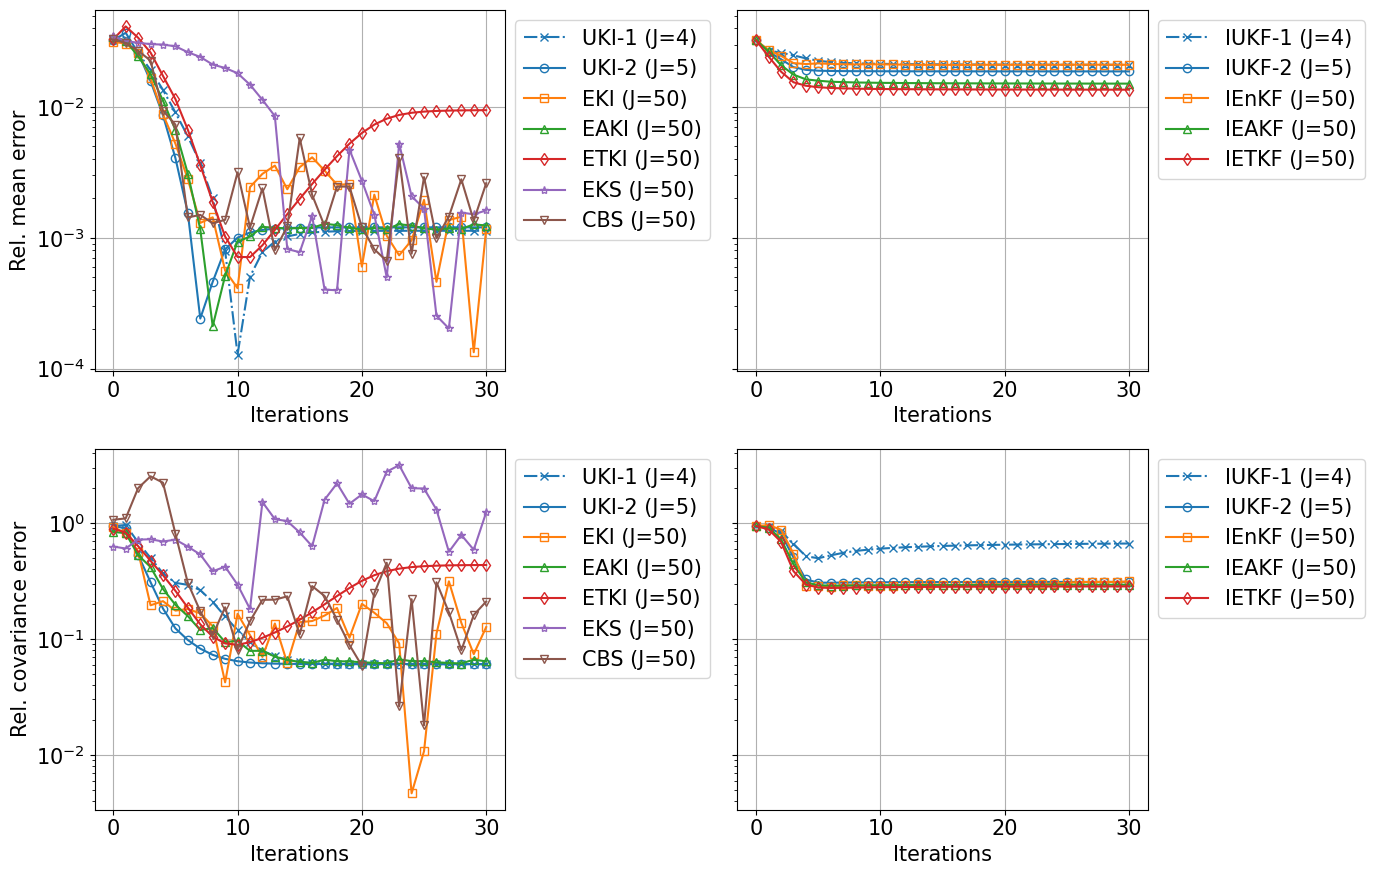

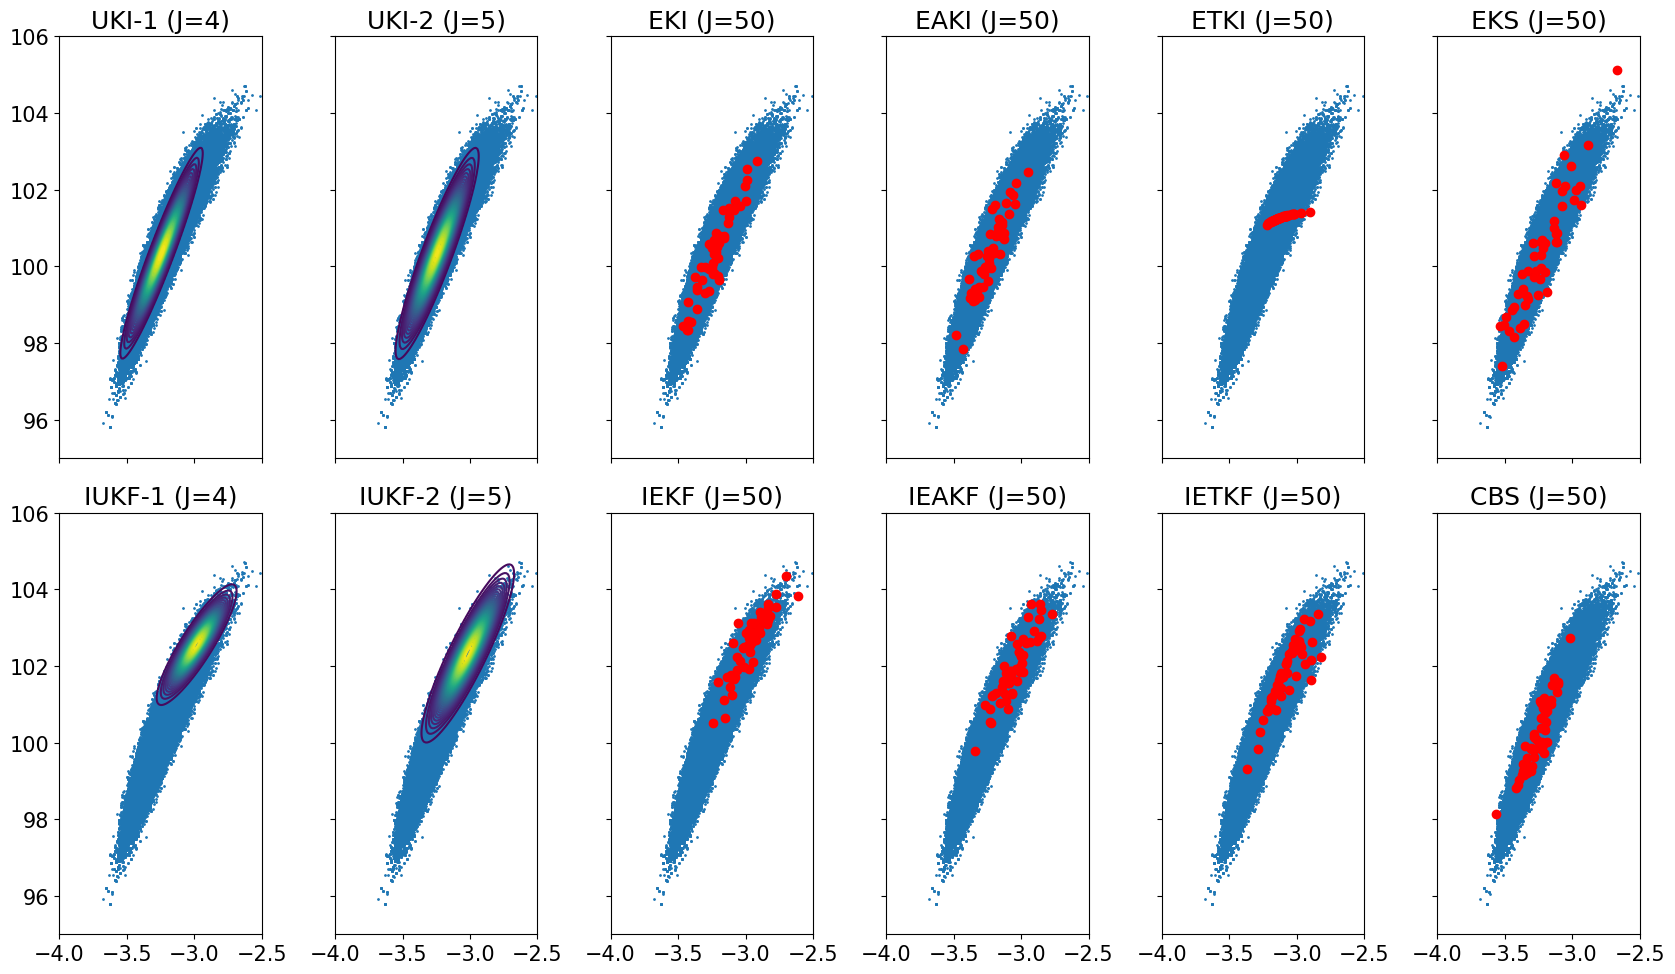

┌ Info: start Ellitic_Posterior_Plot
└ @ Main In[24]:3
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:469
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:469
┌ Info: ("Start ", "EKI", " on the mean-field stochastic dynamical system for Bayesian inference ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:82
┌ Info: ("Start ", "EAKI", " on the mean-field stochastic dynamical system for Bayesian inference ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:82
┌ Info: ("Start ", "ETKI", " on the mean-field stochastic dynamical system for Bayesian inference ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:82


In [25]:
problem_type = "under-determined"
μ0 = [0.0, 100.0]
Σ0    = [1.0^2  0.0; 0.0 1.0^2]
Nt, N_ens = 30, 50
Ellitic_Posterior_Plot(problem_type, μ0, Σ0, Nt, N_ens)

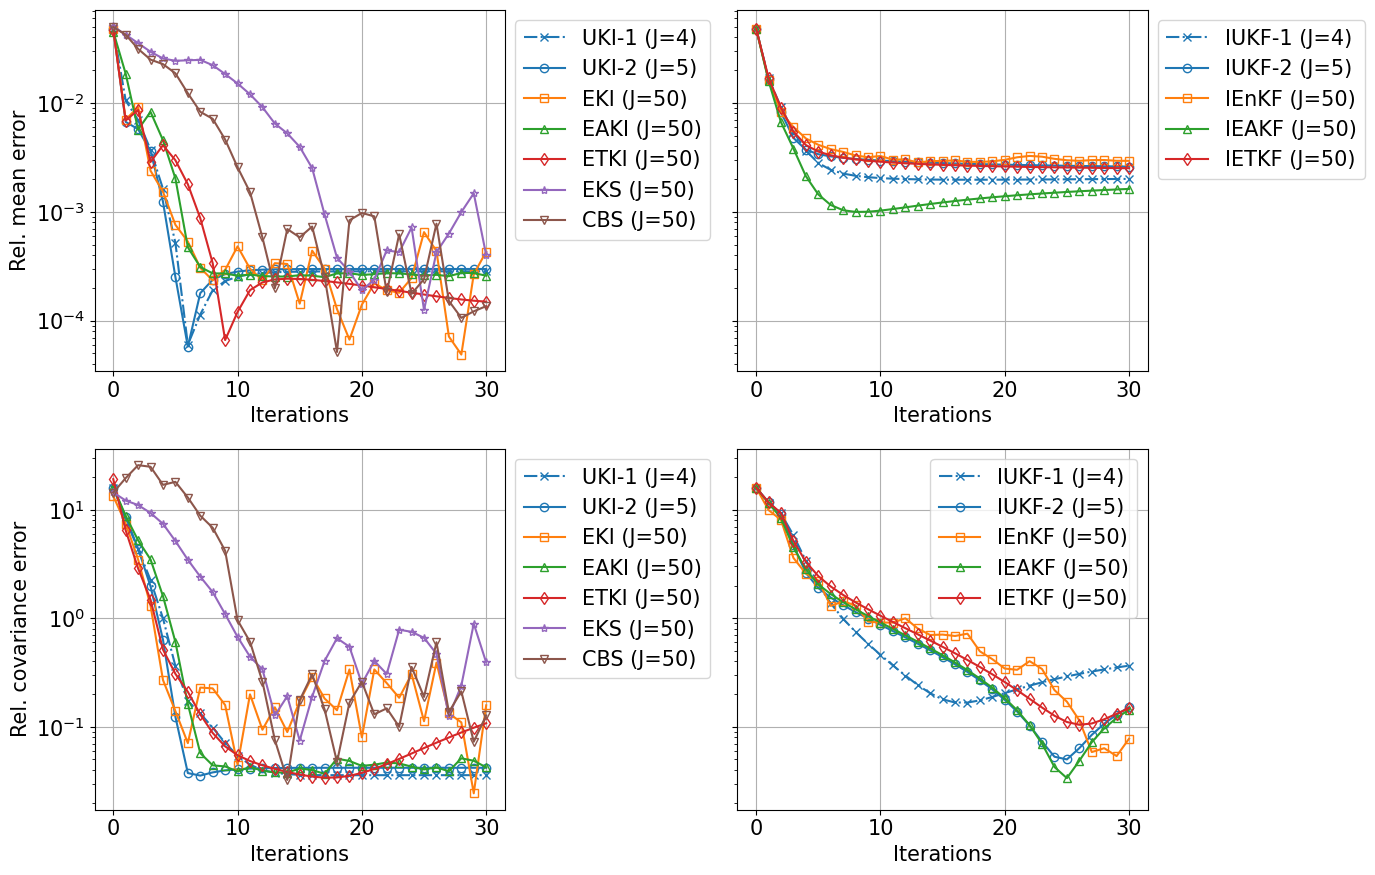

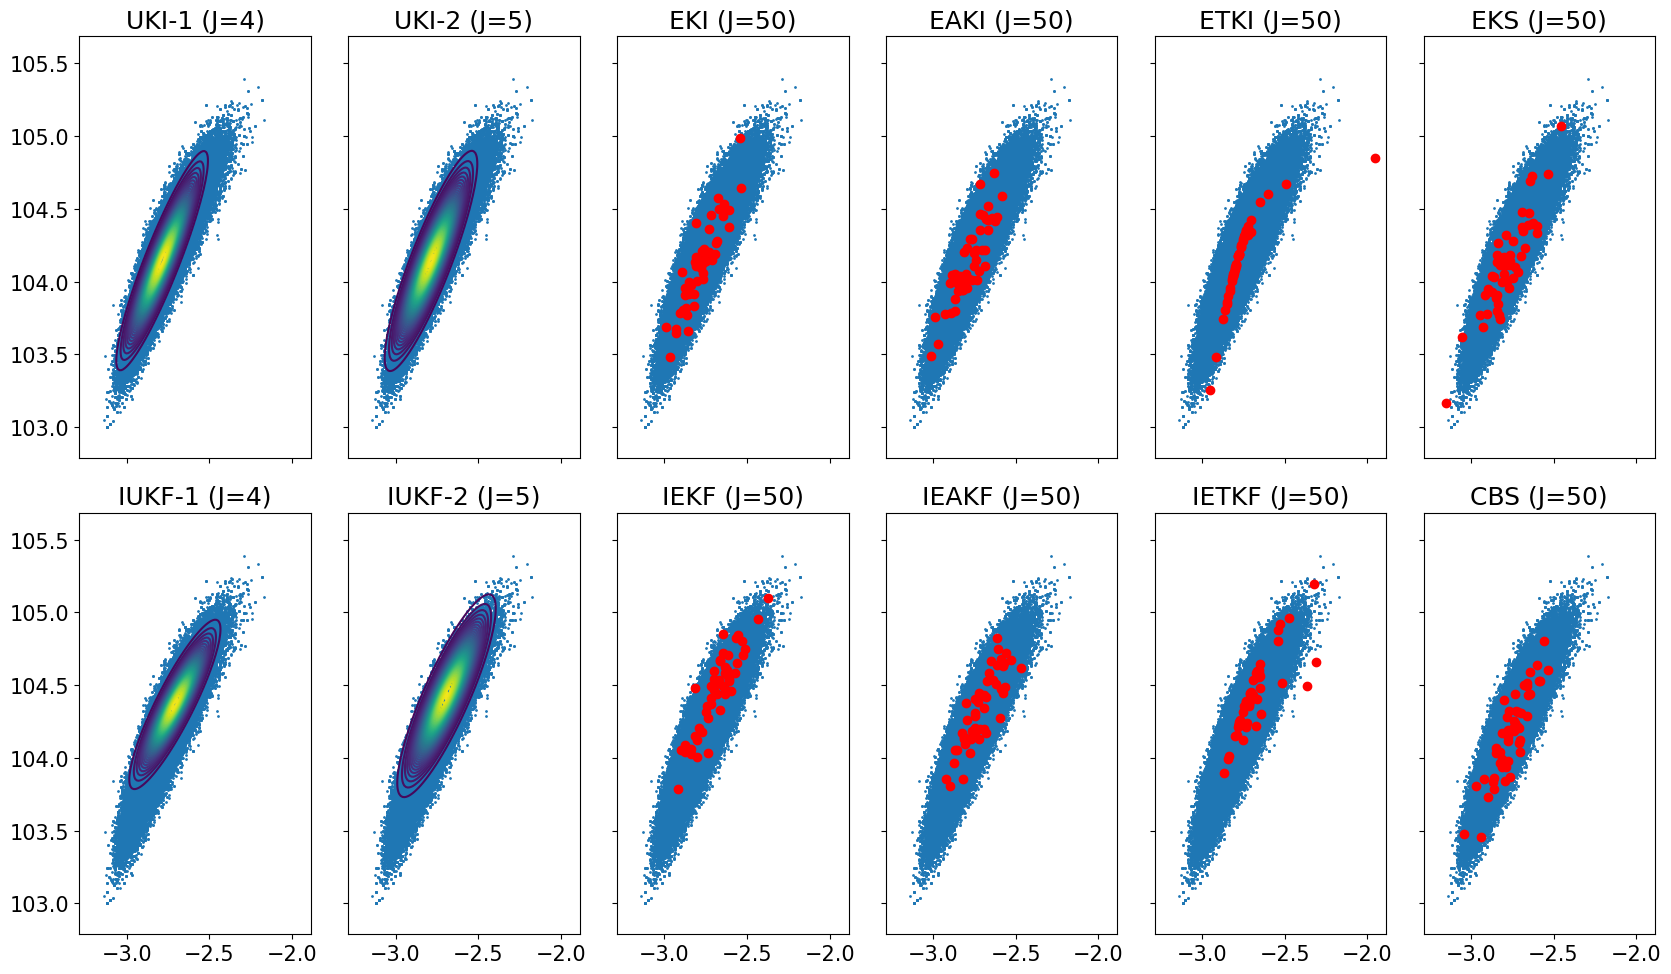

┌ Info: start Ellitic_Posterior_Plot
└ @ Main In[24]:3
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:469
┌ Info: Start UKI on the mean-field stochastic dynamical system for Bayesian inference 
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:469
┌ Info: ("Start ", "EKI", " on the mean-field stochastic dynamical system for Bayesian inference ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:82
┌ Info: ("Start ", "EAKI", " on the mean-field stochastic dynamical system for Bayesian inference ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:82
┌ Info: ("Start ", "ETKI", " on the mean-field stochastic dynamical system for Bayesian inference ")
└ @ Main /Users/huang/Desktop/Code/InverseProblems-master.jl/Inversion/KI.jl:82


In [26]:
problem_type = "well-determined"
μ0 = [0.0, 100.0]
Σ0    = [1.0^2  0.0; 0.0 1.0^2]
Nt, N_ens = 30, 50
Ellitic_Posterior_Plot(problem_type, μ0, Σ0, Nt, N_ens)